In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../core-scripts")
import ShearSpectrum2D
from Utilities import clean_spec_2D, extract_max_re_sig, max_re
import matplotlib.lines as mlines
import ShearSpectrum2D as S2D
from cheb import cheb
import ShearSpectrum2D_ZeroK as S2D_ZeroK

In [5]:
# define the grid that Wan used to make figure 4
gdl,gdr,gdn = 0.0, 1.0, 11
gds = np.linspace(gdl, gdr, gdn)
al, ar, an = 0.0, 2.5, 26
acts = np.linspace(al, ar, an)

 Load in the FEniCS data used by Wan Luo. 
 
 *Luo, Wan, et al. "Flow states of two dimensional active gels driven by external shear." Soft matter 20.4 (2024): 738-753.*

In [7]:
data_path = "../wan-figure-4-data/"
wan_shears = np.loadtxt(data_path+"point_shear")
wan_activities = np.loadtxt(data_path+"point_activity")
wan_states = np.loadtxt(data_path+"point_state")

Load in Chebyshev pseudospectral results.

In [8]:
k_var_evs = np.load("../two-dimensions/data/2D-wan-grid-kx_0-10-MULTIPLE_RES/spectra-mat.npy")
kxs = np.load("../two-dimensions/data/2D-wan-grid-kx_0-10-MULTIPLE_RES/kxs.npy")
acts = np.load("../two-dimensions/data/2D-wan-grid-kx_0-10-MULTIPLE_RES/acts.npy")
gds = np.load("../two-dimensions/data/2D-wan-grid-kx_0-10-MULTIPLE_RES/gds.npy")

# Use only one resolution since 2D spectra match up very well across resolutions
k_var_evs = k_var_evs[:,:,:,0,:]
max_re_evs = extract_max_re_sig(k_var_evs)

## Comparing with Wan's FEniCS results

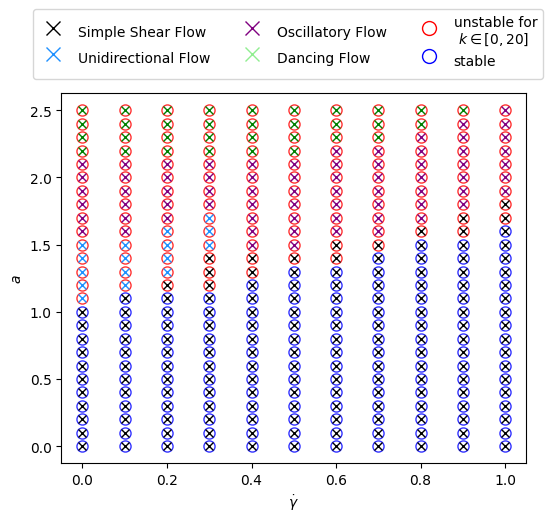

In [9]:
fig, ax = plt.subplots()
# plot pseudospectral results
for i in range(len(gds)):
    for j in range(len(acts)):
        c = "red" if np.real(max_re_evs[i,j])>0 else "blue"
        plt.plot(gds[i], acts[j], "o", markersize=8, fillstyle='none', color=c, picker=True, alpha=0.8)
red_dot = mlines.Line2D([], [], color='red', marker='o', fillstyle='none', linestyle='None',
                      markersize=10, label='unstable for\n $k\in[0,20]$')
blue_dot = mlines.Line2D([], [], color='blue', marker='o', fillstyle='none', linestyle='None',
                      markersize=10, label='stable')

# plot Wan's data on the same plot
num_points = len(wan_shears)
for i in range(num_points):
    if wan_states[i] == 0:
        c = "black"
    elif wan_states[i] == 2:
        c = "dodgerblue"
    elif wan_states[i] == 3:
        c = "purple"
    elif wan_states[i] == 4:
        c = "green"
    ax.plot(wan_shears[i], wan_activities[i], 'x', color=c, alpha=1.0)
lightblue_cross = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
                      markersize=10, label='Simple Shear Flow')
orange_cross = mlines.Line2D([], [], color='dodgerblue', marker='x', linestyle='None',
                      markersize=10, label='Unidirectional Flow')
purple_cross = mlines.Line2D([], [], color='purple', marker='x', linestyle='None',
                      markersize=10, label='Oscillatory Flow')
lightgreen_cross = mlines.Line2D([], [], color='lightgreen', marker='x', linestyle='None',
                      markersize=10, label='Dancing Flow')
ax.legend(handles=[lightblue_cross, orange_cross, purple_cross, lightgreen_cross, red_dot, blue_dot], ncol=3,handleheight=2.4, labelspacing=0.05, loc=(-0.06,1.04))
plt.xlabel("$\dot\gamma$")
plt.ylabel("$a$")
fig.set_figwidth(6)

In [10]:
# Finding the computed values of critical activity in pseudospectral method
m,n = max_re_evs.shape
crit_a = np.zeros(len(gds))

for i in range(len(gds)):
    for j in range(len(acts)-1):
        ev = max_re_evs[i,j]
        next_ev = max_re_evs[i,j+1]
        if np.real(ev) * np.real(next_ev) < 0:
            # print(ev, next_ev)
            crit_a[i] = (acts[j] + acts[j+1]) / 2
            # crit_a[i] = acts[j]
            break

# Analytic expression for the linear stability analysis with 1D perturbation
ell_over_W_sq = 0.01
a1c = 2 * (1 + gds**2) * (1 + np.pi**2 * ell_over_W_sq)
a2c = (1+gds**2) * ((1 + np.pi**2 * ell_over_W_sq)**2 + gds**2) / (1 + np.pi**2 * ell_over_W_sq - gds**2)

# Copy over 3D critical activities from another notebook
crit_a_3D = [1.15, 1.15, 1.15, 1.25, 1.25, 1.35, 1.35, 1.35, 1.25, 1.25, 1.15]# kz=0.3
# crit_a_3D_low = [1.15, 1.15, 1.15, 1.25, 1.25, 1.25, 1.35, 1.35, 1.35, 1.45, 1.35] # kz=0.6
# crit_a_3D_high = [1.15, 1.15, 1.15, 1.25, 1.35, 1.35, 1.35, 1.35, 1.35, 1.45, 1.35]

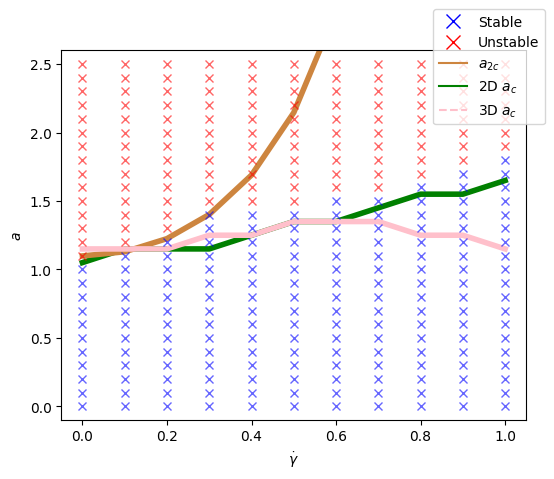

In [11]:
fig, ax = plt.subplots()
plt.plot(gds, crit_a, color="green", linewidth=4, label="Chebyshev in 2D")
# plt.plot(gds, a1c, color='blue', linewidth=5)
plt.plot(gds, a2c, color="peru", linewidth=4)
plt.plot(gds, crit_a_3D, color='pink', linewidth=4)
# plt.plot(gds, crit_a_3D_high, '--', color='pink', linewidth=2)
stab_1D_2 = mlines.Line2D([], [], color='peru', label='$a_{2c}$')
# stab_1D_1 = mlines.Line2D([], [], color='blue', label='$a_{1c}$')
stab_2D = mlines.Line2D([], [], color='green', label='2D $a_c$')
stab_3D = mlines.Line2D([], [], linestyle='--', color='pink', label='3D $a_c$')

# plot Wan's full nonlinear numerical solution on the same plot
num_points = len(wan_shears)
for i in range(num_points):
    if wan_states[i] == 0:
        c = "blue"
    else:
        c = "red"
    ax.plot(wan_shears[i], wan_activities[i], 'x', color=c, alpha=0.6)
lightblue_cross = mlines.Line2D([], [], color='blue', marker='x', linestyle='None',
                      markersize=10, label='Stable')
red_cross = mlines.Line2D([], [], color='red', marker='x', linestyle='None',
                      markersize=10, label='Unstable')
ax.legend(handles=[lightblue_cross, red_cross, stab_1D_2, stab_2D, stab_3D], ncol=1, loc=(0.8, 0.8))#, ncol=2,handleheight=2.4, labelspacing=0.05, loc=(-0.06,1.04))
plt.xlabel("$\dot\gamma$")
plt.ylabel("$a$")
plt.ylim([-0.1, 2.6])
fig.set_figwidth(6)

# plt.title("$l^2/W^2=0.04$")
# NOTE: Do again with Wan's channel length, with (l/W)^2 = 0.04 instead of 0.01

Numerical magnitude of the 2D eigenvalues

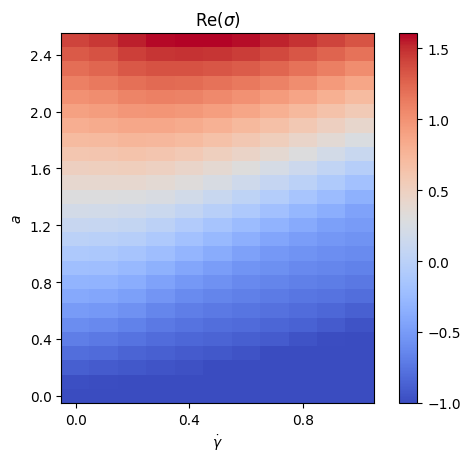

In [19]:
plt.imshow(max_re_evs.T.real, aspect=0.5, origin='lower', cmap='coolwarm')
plt.title('Re($\sigma$)')
plt.colorbar()
plt.xlabel("$\dot\gamma$")
plt.ylabel("$a$")
plt.xticks(np.arange(0, gdn, 4), np.round(gds[::4],3))
plt.yticks(np.arange(0, an, 4), np.round(acts[::4],3));

## Studying the discrepancy in the plot

In [2]:
import os 
import sys
sys.path.append("../../core-scripts")
from Utilities import max_re
import matplotlib.pyplot as plt
import numpy as np

# Load in linear stability analysis data
folder_name = "data/2D-wan-grid-kx_0-20/"
kx = np.load(os.path.join(folder_name, "kxs.npy"))
gd = np.load(os.path.join(folder_name, "gds.npy"))
a = np.load(os.path.join(folder_name, "acts.npy"))
spec_mat = np.load(os.path.join(folder_name, "spectra-mat.npy"))

# Load in the data that Wan used to generate Figure 4 in her flow states paper
data_path = "../../wan-figure-4-data-comparison/"
wan_shears = np.loadtxt(data_path+"point_shear")
wan_activities = np.loadtxt(data_path+"point_activity")
wan_states = np.loadtxt(data_path+"point_state")

In [3]:
# sort each spectra first 
for i in range(len(gd)):
    for j in range(len(a)):
        for k in range(len(kx)):
            evs = spec_mat[k,i,j,:]
            spec_mat[k,i,j,:] = evs[np.argsort(-evs.real)]

# Take the max over each k, and search for the indices where there is discrepancy
spec_mat_max = np.zeros((len(gd), len(a)), dtype=np.complex128)
disc_idx = []
for i in range(len(gd)):
    for j in range(len(a)):
            spec_mat_max[i,j] = max_re(spec_mat[:,i,j,0])[0]
            if spec_mat_max[i,j].real>0 and wan_states[i*len(a) + j]==0:
                 disc_idx.append((i,j))

In [14]:
# NOTE: Uncomment to confirm that the data still gives the same stability plot
# for i in range(len(gd)):
#     for j in range(len(a)):
#         c = "red" if spec_mat_max[i,j]>0 else "blue"
#         plt.plot(gd[i], a[j], "o", markersize=8, fillstyle='none', color=c, picker=True, alpha=0.8)
# red_dot = mlines.Line2D([], [], color='red', marker='o', fillstyle='none', linestyle='None',
#                       markersize=10, label='unstable for\n $k\in[0,20]$')
# blue_dot = mlines.Line2D([], [], color='blue', marker='o', fillstyle='none', linestyle='None',
#                       markersize=10, label='stable')

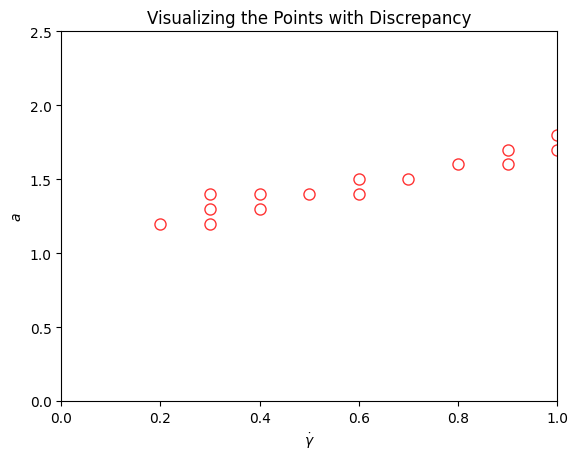

In [4]:
# Plot the points where there are disagreements 
for i, j in disc_idx:
    # print(spec_mat_max[i,j])
    plt.plot(gd[i], a[j], "o", markersize=8, fillstyle='none', color='red', picker=True, alpha=0.8)
plt.xlim([0,1])
plt.ylim([0,2.5])
plt.xlabel("$\dot\gamma$")
plt.ylabel("$a$")
plt.title("Visualizing the Points with Discrepancy");

The analysis below shows that it is not because Wan's channel does not admit the wavelengths that the infinite-length channel admits. If it is a correct analysis, then it must be the case that somehow the linear stability is overly sensitive to the change in $k$.

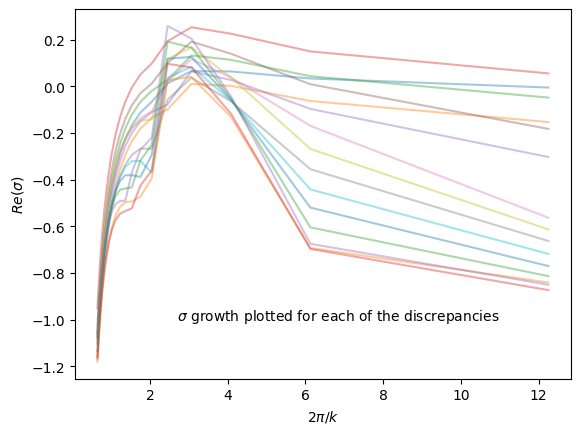

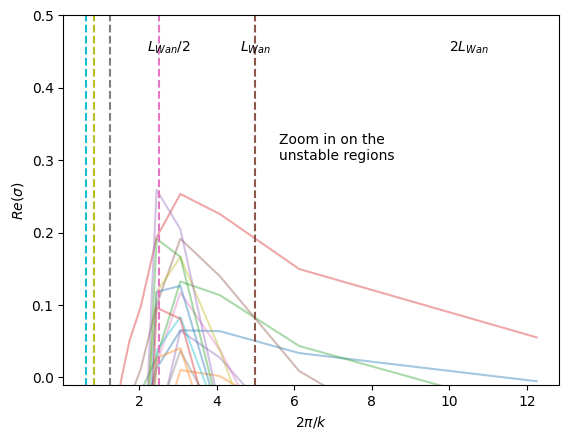

In [5]:
plt.figure()
for i,j in disc_idx:
    ev_k = spec_mat[:,i,j,0]
    plt.plot(2*np.pi / kx[1:20], ev_k.real[1:20], alpha=0.4)
# plt.plot(kx[0:10], spec_mat[0:10,2,23,0].real)
# plt.ylim([-0.05, 0.2])
plt.ylabel("$Re(\sigma)$")
plt.xlabel("$2\pi/k$")
plt.text(2.7, -1.0, "$\sigma$ growth plotted for each of the discrepancies")
plt.show()

WAN_CHNL_LEN = 2.5 # Five times the width
for i,j in disc_idx:
    ev_k = spec_mat[:,i,j,0]
    plt.plot(2*np.pi / kx[1:20], ev_k.real[1:20], alpha=0.4)
    
plt.plot(np.zeros(10)+2*WAN_CHNL_LEN, np.linspace(-1.0,0.5,10), '--')
plt.plot(np.zeros(10)+WAN_CHNL_LEN, np.linspace(-1.0,0.5,10), '--')
plt.plot(np.zeros(10)+WAN_CHNL_LEN/2, np.linspace(-1.0,0.5,10), '--')
plt.plot(np.zeros(10)+WAN_CHNL_LEN/3, np.linspace(-1.0,0.5,10), '--')
plt.plot(np.zeros(10)+WAN_CHNL_LEN/4, np.linspace(-1.0,0.5,10), '--')

plt.ylim([-0.01, 0.5])
plt.ylabel("$Re(\sigma)$")
plt.xlabel("$2\pi/k$")
plt.text(4.6,0.45,"$L_{Wan}$")
plt.text(10,0.45,"$2L_{Wan}$")
plt.text(2.2,0.45,"$L_{Wan}/2$")
plt.text(5.6,0.3, "Zoom in on the \nunstable regions")
plt.show()

### Plotting the 2D Linear Stability at Different Resolutions
Different resolutions do not change the critical activity boundary

In [17]:
import sys
sys.path.append("../../core-scripts")
import Utilities
import os

folder_name = "data/2D-wan-grid-kx_0-10-MULTIPLE_RES/"
kx = np.load(os.path.join(folder_name, "kxs.npy"))
gd = np.load(os.path.join(folder_name, "gds.npy"))
a = np.load(os.path.join(folder_name, "acts.npy"))
spec_mat = np.load(os.path.join(folder_name, "spectra-mat.npy"))
print(spec_mat.shape)

(30, 11, 26, 3, 50)


Text(0.5, 1.0, '2D Critical Activity at Different Chebyshev Grid Resolutions')

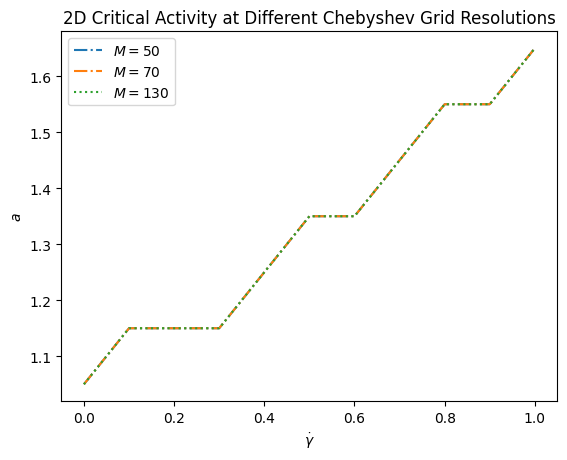

In [18]:
NUM_RES = spec_mat.shape[3]
styles = ['dashdot','-.',':']
RESOLUTIONS = ["50", "70", "130"]
for i in range(NUM_RES):
    max_re_sig = Utilities.extract_max_re_sig(spec_mat[:,:,:,i,:])
    crit_a = Utilities.extract_crit_a(max_re_sig, a)
    plt.plot(gd, crit_a, label=f"$M={RESOLUTIONS[i]}$", linestyle=styles[i])
plt.legend()
plt.xlabel("$\dot\gamma$")
plt.ylabel("$a$")
plt.title("2D Critical Activity at Different Chebyshev Grid Resolutions")

In [86]:
l_evs = []
h_evs = []

for i in range(len(acts)):
    l = ShearSpectrum2D.spectrum(1, 0.0, 1, acts[i])
    h = ShearSpectrum2D.spectrum(1, 0.0, 1, acts[i], _ell_over_W_squared=0.04)
    l_evs.append(max_re(l)[0])
    h_evs.append(max_re(h)[0])

Text(0.5, 1.0, 'Correlation length affects 2D linear stability even at zero shear')

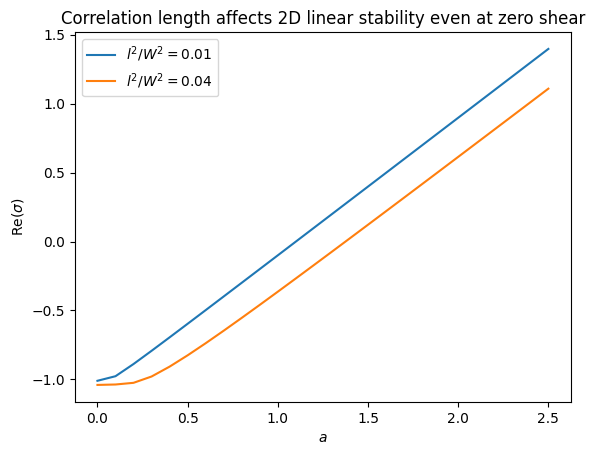

In [93]:
# print(l_evs)
# print(h_evs)
plt.figure()
l_evs = np.array(l_evs, dtype=np.complex128)
h_evs = np.array(h_evs, dtype=np.complex128)
plt.plot(acts, l_evs.real, label="$l^2/W^2=0.01$")
plt.plot(acts, h_evs.real, label="$l^2/W^2=0.04$")
plt.legend()
plt.ylabel("Re($\sigma$)")
plt.xlabel("$a$")
plt.title("Correlation length affects 2D linear stability even at zero shear")